In [23]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as cx


# Read the letters
letters = pd.read_csv('../data/letters.csv',encoding='utf-8')
# group by place and location
places = letters.groupby(['place', 'location']).size().reset_index(name='count')
letters = letters.drop(columns=['location'])
places['place_id'] = places.index + 1
places = places.drop(columns=['count'])

cols = places.columns.tolist()
cols = cols[-1:] + cols[:-1]
places = places[cols]

In [24]:
# parse into geopandas
places["geometry"] = places["location"].str.split(",")

places['geometry'] = places['geometry'].apply(lambda x: x[:-1])

# convert geometry to wkt from [lat,lon] to POINT(lon lat)
places['geometry'] = places['geometry'].apply(lambda x: 'POINT (' + x[1] + ' ' + x[0] + ')')
# geometry to geometry object

places['geometry'] = places['geometry'].apply(wkt.loads)

# convert to geodataframe
gplaces = gpd.GeoDataFrame(places, geometry='geometry')

# remove location col
gplaces = gplaces.drop(columns=['location'])

# rename place to name



In [25]:
gplaces

,place_id,place,geometry
0,1,Angerborg (Węgorzewo),POINT (21.74163 54.21359)
1,2,Arys (Orzysz),POINT (21.9473 53.80989)
2,3,Arys (Orzysz),POINT (21.9473 53.80989)
3,4,Augostov (Augustów),POINT (22.9796 53.84344)
4,5,"Bakkely, Regstrup, Fyn",POINT (10.76257 55.35196)
...,...,...,...
70,71,Vauxtin,POINT (3.60215 49.3502)
71,72,Villeselve,POINT (3.10962 49.69007)
72,73,Vivaise,POINT (3.55993 49.61988)
73,74,Willenberg (Wielbark),POINT (20.94576 53.39815)


In [26]:
# merge places into letters
placed_letters = letters.merge(gplaces[['place','place_id']], on='place',how='left',)
placed_letters.place_id = placed_letters.place_id.fillna(0).astype(int)
placed_letters = placed_letters.drop(columns=['place'])
#placed_letters.value_counts('place_id')

gplaces = gplaces.rename(columns={'place': 'name'})

# save to file
gplaces.to_csv('../data/places.csv', index=False, encoding='utf-8')

# write to csv
placed_letters.to_csv('../data/placed_letters.csv', index=False)


## clean up steps

In [27]:
import requests

def get_lat_lon(p):
    point = p.centroid
    return point.y, point.x


# Add OSM and Google Maps links
gplaces['lat_lon'] = gplaces['geometry'].apply(get_lat_lon)
gplaces['osm_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.openstreetmap.org/?mlat={x[0]}&mlon={x[1]}&zoom=12")
gplaces['google_maps_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.google.com/maps/?q={x[0]},{x[1]}")

def reverse_geocode(lat_lon):
    base_url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        'format': 'jsonv2',
        'lat': lat_lon[0],
        'lon': lat_lon[1]
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get('address', {}).get('city', 'Unknown')
    else:
        return 'Error'

# Add closest city name
# gplaces['closest_city'] = gplaces['lat_lon'].apply(reverse_geocode)

# Drop the lat_lon column if it's not needed
gplaces.drop(columns=['lat_lon'], inplace=True)

# Save to CSV
gplaces.to_csv('../data/places_cleanup.csv', index=False, encoding='utf-8')

In [28]:
gplaces

,place_id,name,geometry,osm_link,google_maps_link
0,1,Angerborg (Węgorzewo),POINT (21.74163 54.21359),https://www.openstreetmap.org/?mlat=54.21359&m...,"https://www.google.com/maps/?q=54.21359,21.741..."
1,2,Arys (Orzysz),POINT (21.9473 53.80989),https://www.openstreetmap.org/?mlat=53.80989&m...,"https://www.google.com/maps/?q=53.80989,21.9473"
2,3,Arys (Orzysz),POINT (21.9473 53.80989),https://www.openstreetmap.org/?mlat=53.80989&m...,"https://www.google.com/maps/?q=53.80989,21.9473"
3,4,Augostov (Augustów),POINT (22.9796 53.84344),https://www.openstreetmap.org/?mlat=53.8434431...,"https://www.google.com/maps/?q=53.8434431,22.9..."
4,5,"Bakkely, Regstrup, Fyn",POINT (10.76257 55.35196),https://www.openstreetmap.org/?mlat=55.3519638...,https://www.google.com/maps/?q=55.351963874999...
...,...,...,...,...,...
70,71,Vauxtin,POINT (3.60215 49.3502),https://www.openstreetmap.org/?mlat=49.3501987...,"https://www.google.com/maps/?q=49.3501987,3.60..."
71,72,Villeselve,POINT (3.10962 49.69007),https://www.openstreetmap.org/?mlat=49.6900681...,"https://www.google.com/maps/?q=49.6900681,3.10..."
72,73,Vivaise,POINT (3.55993 49.61988),https://www.openstreetmap.org/?mlat=49.6198789...,"https://www.google.com/maps/?q=49.6198789,3.55..."
73,74,Willenberg (Wielbark),POINT (20.94576 53.39815),https://www.openstreetmap.org/?mlat=53.3981483...,"https://www.google.com/maps/?q=53.3981483,20.9..."


In [31]:
gdf1914world = gpd.read_file('../maps/1914/1914.geojson')
# remove the world outside 
ylim=(43,60)
xlim=(-3,40)

# remove countries outside the map
gdf1914 = gdf1914world.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]


In [ ]:
# given the geometry column of gplaces the geodataframe gdf1914, add a country column to gplaces with country name
# use a spatial join to find the country of each place


,OBJECTID_12,OBJECTID,NAME,geometry
88,89,1155,Belgium,"MULTIPOLYGON (((4.92604 51.43283, 4.92576 51.4..."
89,90,1078,Bulgaria,"POLYGON ((22.7023 44.20833, 22.72297 44.2029, ..."
90,91,1115,Switzerland,"POLYGON ((9.01532 45.82857, 9.00807 45.82912, ..."
91,92,1221,Denmark,"MULTIPOLYGON (((11.51389 54.82972, 11.56444 54..."
92,93,1448,Finland,"MULTIPOLYGON (((23.70583 59.92722, 23.64944 59..."
93,94,1097,France,"MULTIPOLYGON (((-3.58222 48.80389, -3.58278 48..."
94,95,1132,Guernsey,"POLYGON ((-2.50097 49.50389, -2.52847 49.42639..."
100,101,1049,Italy,"MULTIPOLYGON (((12.31434 45.34133, 12.36917 45..."
101,102,1130,Jersey,"POLYGON ((-2.03847 49.24334, -2.01681 49.23104..."
102,103,1108,Liechtenstein,"POLYGON ((9.55267 47.24386, 9.57326 47.21906, ..."


<Axes: >

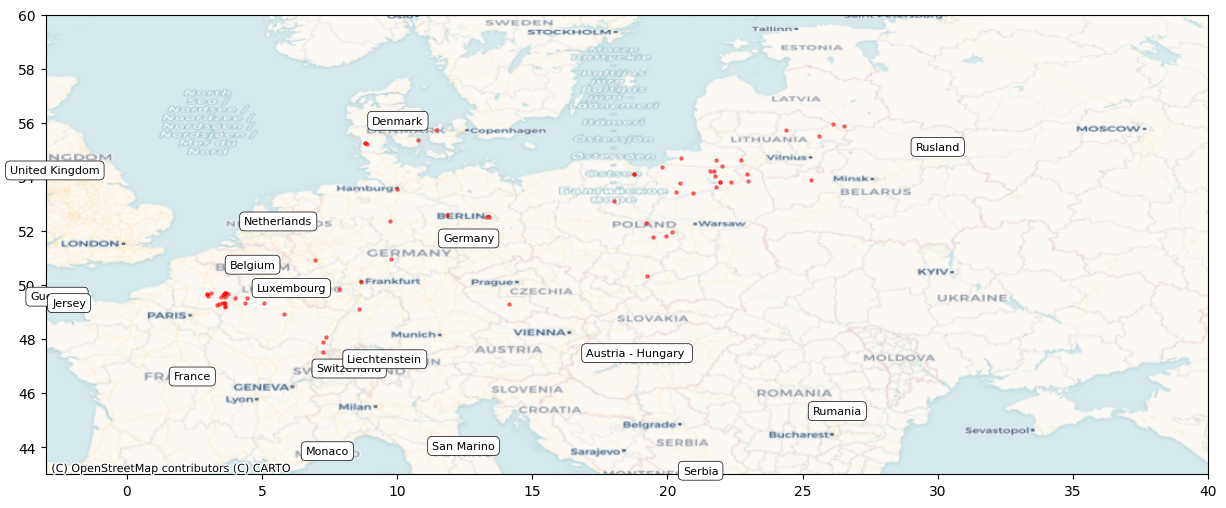

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))



ax.set_ylim(43, 60)
ax.set_xlim(-3, 40)
#gdf1914.plot(ax=ax, cmap="tab20c", edgecolor="black", alpha=0.5)
gdf1914.apply(
    lambda x: ax.annotate(
        x.NAME,
        xy=x.geometry.centroid.coords[0],
        ha="center",
        size=8,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
    ),
    axis=1,
)
ax.annotate(
    "Rusland",
    xy=(30, 55),
    ha="center",
    size=8,
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
)

cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.CartoDB.Voyager)
gplaces.plot(ax=ax, edgecolor="red", markersize=5, alpha=0.5, color="red")